In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
from numpy.linalg import multi_dot
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
%matplotlib inline


## TIme series

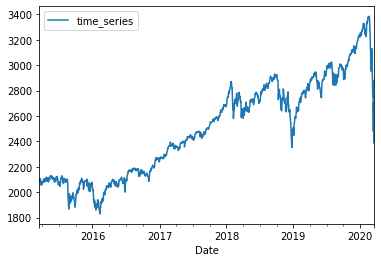

In [2]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

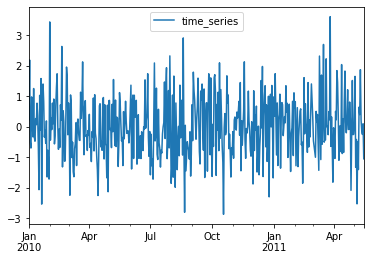

In [3]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white.plot();

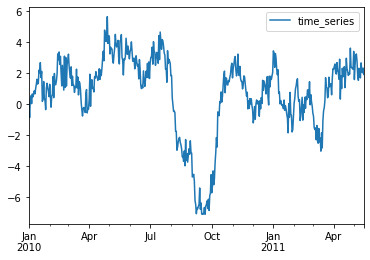

In [4]:
arm_np = np.zeros(501)
mean = 0.0
ar = -.4
ma = -.7
eps = np.random.standard_normal()
for i in range(1, 501):
    arm_np[i] = mean + ar * arm_np[i-1] + ma * eps
    eps = np.random.standard_normal()
arima_np = arm_np.cumsum()
df_arima = pd.DataFrame(arima_np)
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_arima = time_series_preparation.transform(df_arima)
df_arima.plot()

## Test functions

In [5]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

In [6]:
def run_giotto_ar(df, test_size, p):
    model = AR(horizon=test_size, p=p)
    df_train = df
    df_test = df.iloc[-test_size:]
    model = model.fit(df_train)
    pred_g = model.predict()
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    print('Basic AR results results:')
    print(f'Fitted parameters: mu={model.model.estimators_[0].intercept_:.2f}, p={model.model.estimators_[0].coef_}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    return model.model.estimators_[0].coef_

mar = run_giotto_ar(df_white, 100, 4)
mar

Basic AR results results:
Fitted parameters: mu=-0.02, p=[-0.03  0.02  0.03 -0.05]
RMSE: 1.10



array([-0.03,  0.02,  0.03, -0.05])

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.94], q=[-0.06 -1.    0.03  0.03]
AR roots abs:[1.06]
MA roots abs:[5.75 4.85 1.04 1.  ]
Train error mean: -0.45, std: 20.82
LL: 5150.12
RMSE: 46634.73



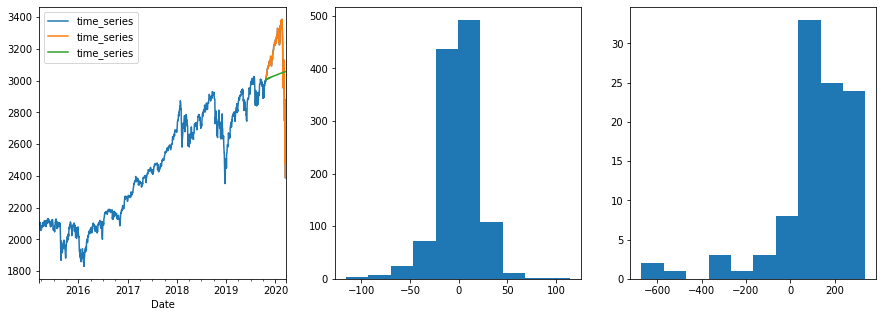

In [7]:
def run_giotto_arima(df, test_size, order, method='css-mle', plot=True):
    model = ARIMA(horizon=test_size, order=order, method=method)
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    pred_g = model.predict(df_test.iloc[[0]])
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.phi_
    theta = model.model.theta_
    mu = model.model.mu_
    train_errors = model.model.errors_
    print(f'Giotto results {method}:')
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {model.model.model.ml:.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    if plot:
        test_errors = df_test -  y_pred
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)
    return mu, phi, theta
    
mu, phi, theta = run_giotto_arima(df_real, 100, (1, 2, 4), 'css')

Statsmodels results css:
Fitted parameters: mu=-0.00, p=[-0.94], q=[-0.06 -1.    0.03  0.03]
AR roots abs:[1.06]
MA roots abs:[1.   1.04 4.86 5.76]
Train error mean: -0.45, std: 20.82
LL: 5150.12
RMSE: 49918.90



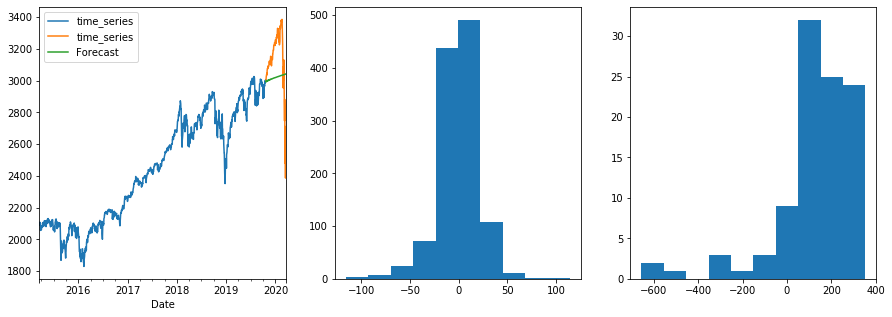

In [8]:
def run_sm(df, test_size, order, method='css-mle', plot=True):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    print(f'Statsmodels results {method}:')
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {-f.llf:.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test.values.flatten() -  y2
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)
    return f, m2

f = run_sm(df_real, 100, (1, 2, 4), 'css')

In [9]:
def run_tests(df, order):
    run_sm(df, 100, order, 'css', plot=True);
#     run_sm(df, 100, order, 'mle', plot=False);
    run_giotto_arima(df, 100, order, 'css', plot=True);
#     run_giotto_arima(df, 100, order, 'mle', plot=False);

## Simple AR check

Basic AR results results:
Fitted parameters: mu=-0.02, p=[-0.03  0.01]
RMSE: 1.11

Statsmodels results css:
Fitted parameters: mu=-0.02, p=[-0.03  0.01], q=[]
AR roots abs:[7.1 9.4]
MA roots abs:[]
Train error mean: -0.00, std: 1.00
LL: 565.86
RMSE: 1.10

Giotto results css:
Fitted parameters: mu=-0.02, p=[-0.03  0.02], q=[]
AR roots abs:[9.38 7.09]
MA roots abs:[]
Train error mean: 0.00, std: 1.00
LL: 565.86
RMSE: 1.10



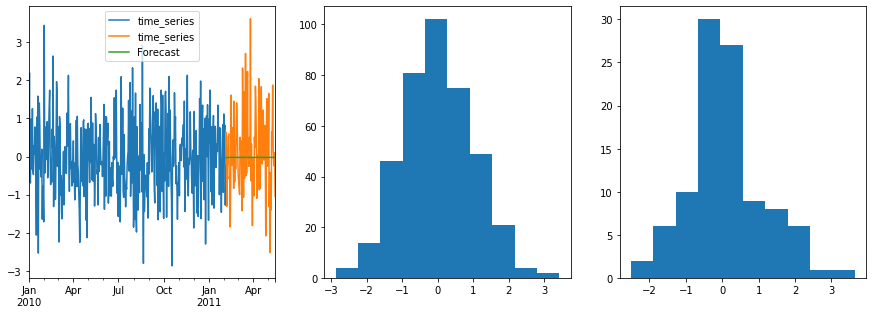

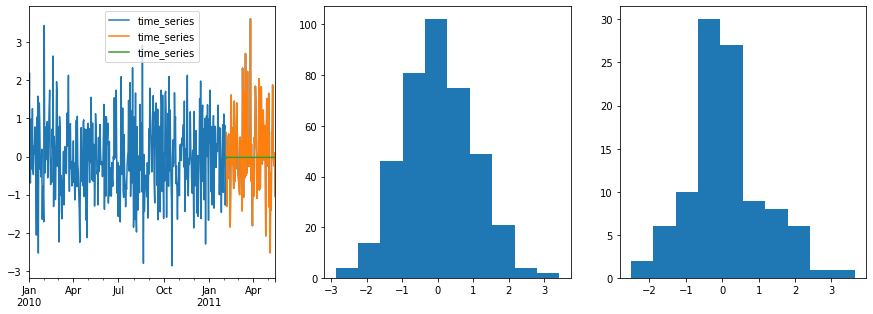

In [10]:
df = df_white
order = (2, 0, 0)
run_giotto_ar(df, 100, 2)
run_tests(df, order)

Basic AR results results:
Fitted parameters: mu=3.58, p=[0.98 0.02]
RMSE: 44772.60

Statsmodels results css:
Fitted parameters: mu=3261.40, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   49.74]
MA roots abs:[]
Train error mean: -0.02, std: 20.81
LL: 5153.70
RMSE: 52639.91

Giotto results css:
Fitted parameters: mu=2442.07, p=[0.98 0.02], q=[]
AR roots abs:[53.89  1.  ]
MA roots abs:[]
Train error mean: 0.80, std: 20.81
LL: 5154.55
RMSE: 63820.28



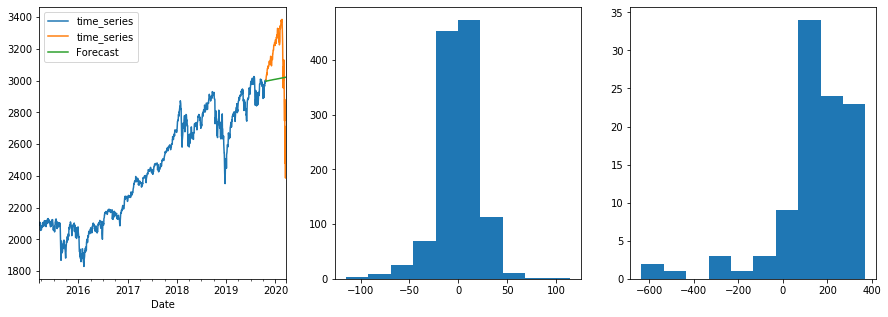

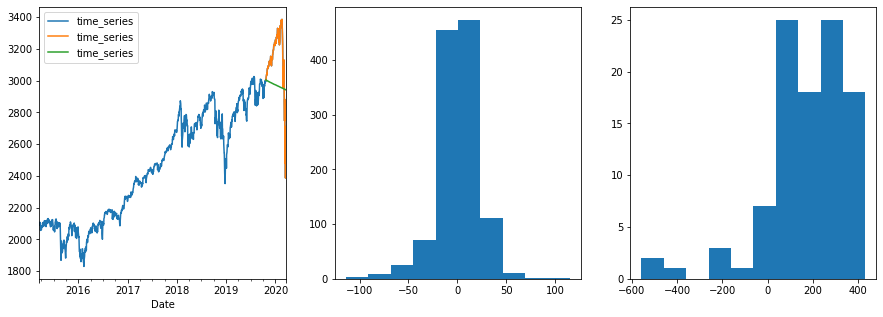

In [11]:
df = df_real
order = (2, 0, 0)
run_giotto_ar(df, 100, 2)
run_tests(df, order)

## Simple ARI check

Statsmodels results css:
Fitted parameters: mu=-0.00, p=[-0.71 -0.35], q=[]
AR roots abs:[1.68 1.68]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 618.98
RMSE: 1.48

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.68 -0.32], q=[]
AR roots abs:[1.76 1.76]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 619.25
RMSE: 1.13



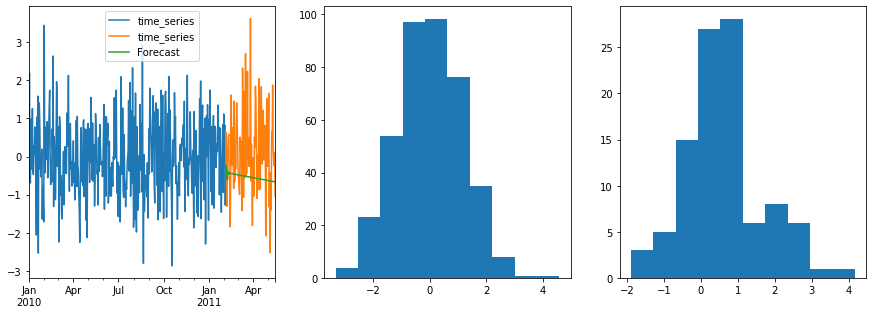

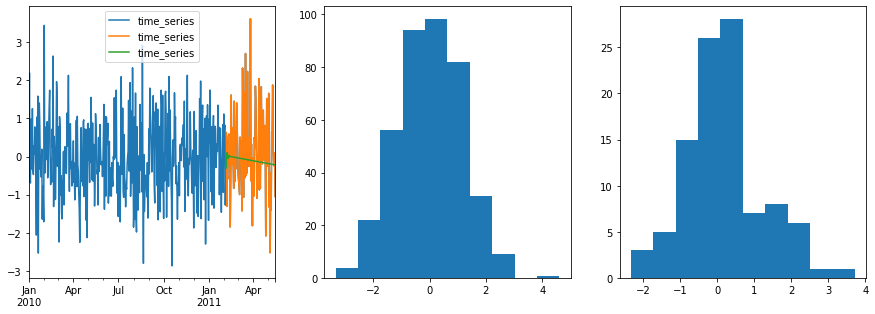

In [12]:
df = df_white
order = (2, 1, 0)
run_tests(df, order)

Statsmodels results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
LL: 5147.77
RMSE: 46983.52

Giotto results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: -0.01, std: 20.78
LL: 5147.77
RMSE: 45021.77



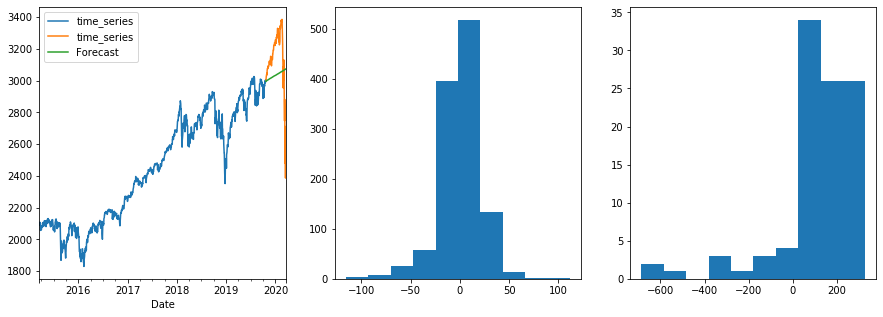

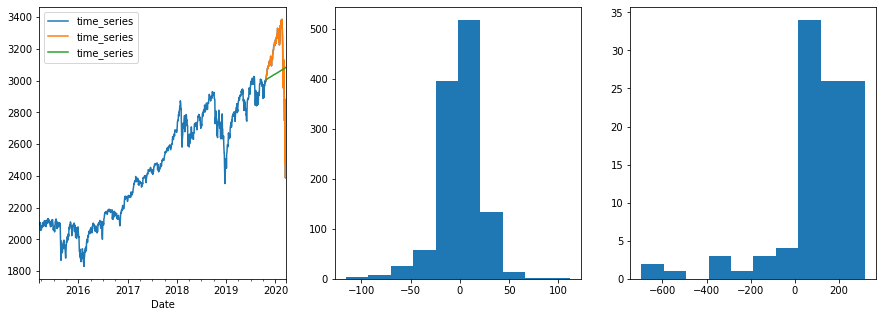

In [13]:
df = df_real
order = (2, 1, 0)
run_tests(df, order)

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.43  0.02], q=[]
AR roots abs:[ 2.15 26.81]
MA roots abs:[]
Train error mean: 0.00, std: 0.68
LL: 413.09
RMSE: 2.77

Giotto results css:
Fitted parameters: mu=0.00, p=[-0.43  0.02], q=[]
AR roots abs:[26.81  2.15]
MA roots abs:[]
Train error mean: 0.00, std: 0.68
LL: 413.09
RMSE: 3.08



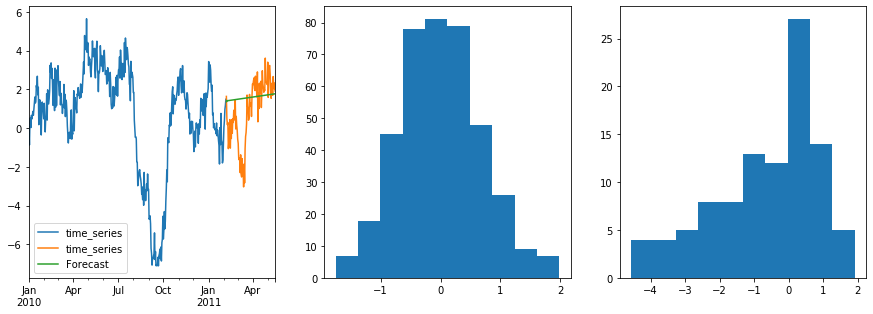

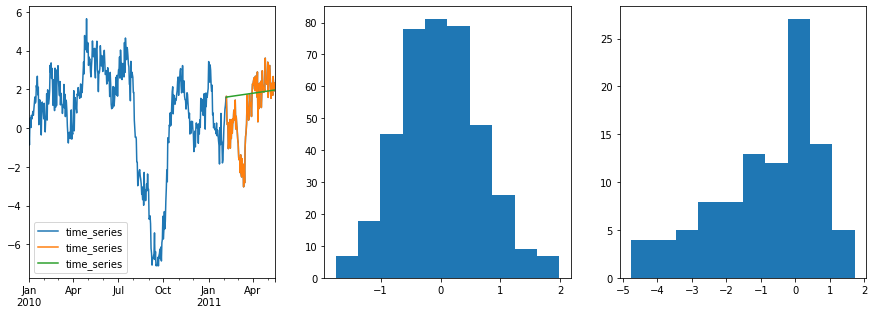

In [14]:
df = df_arima
order = (2, 1, 0)
run_tests(df, order)

## Full ARIMA check

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.19  0.  ], q=[-0.85 -0.15]
AR roots abs:[ 4.97 78.06]
MA roots abs:[1.   6.53]
Train error mean: 0.00, std: 1.00
LL: 564.78
RMSE: 1.09

Giotto results css:
Fitted parameters: mu=0.00, p=[-0.19  0.  ], q=[-0.85 -0.15]
AR roots abs:[76.15  4.97]
MA roots abs:[6.54 1.  ]
Train error mean: 0.00, std: 1.00
LL: 564.78
RMSE: 1.09



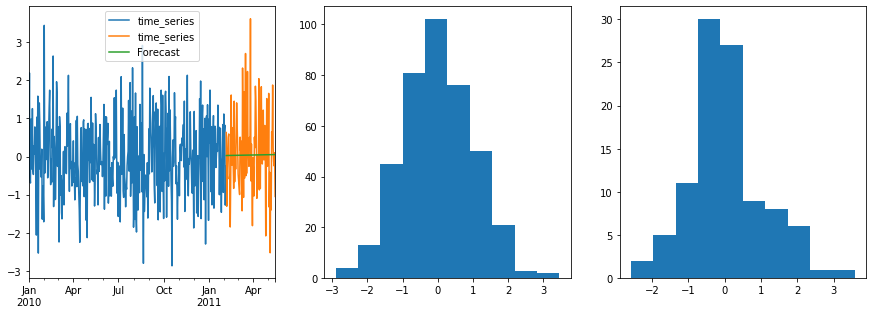

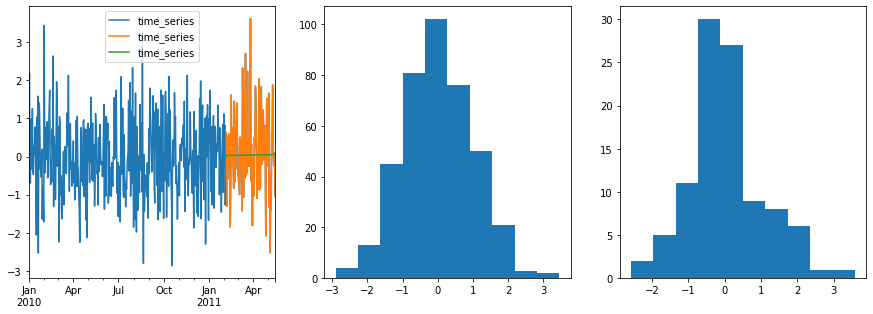

In [15]:
df = df_white
order = (2, 1, 2)
run_tests(df, order)

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.26 -0.07], q=[-0.76 -0.24]
AR roots abs:[3.89 3.89]
MA roots abs:[1.   4.23]
Train error mean: -0.04, std: 20.78
LL: 5143.23
RMSE: 43110.28

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.82 -0.06], q=[-0.18 -0.81]
AR roots abs:[12.11  1.35]
MA roots abs:[1.23 1.01]
Train error mean: -0.42, std: 20.87
LL: 5148.38
RMSE: 45521.01



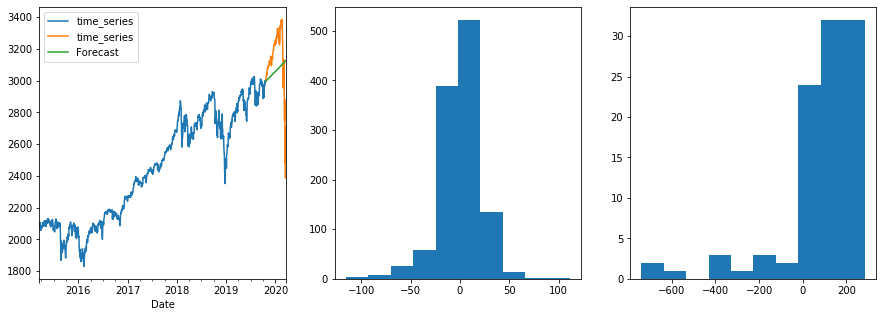

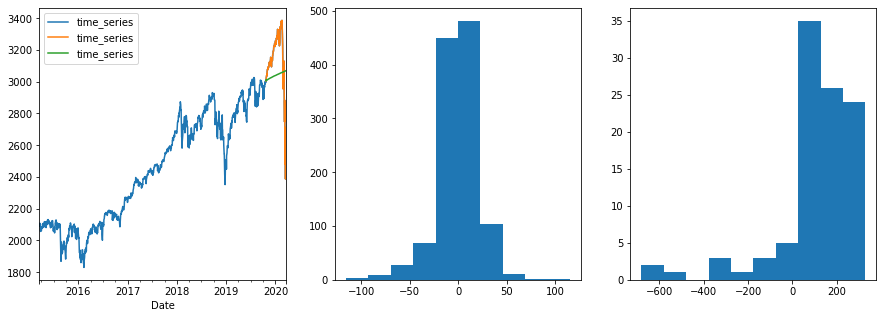

In [16]:
df = df_real
order = (2, 2, 2)
run_tests(df, order)

Statsmodels results css:
Fitted parameters: mu=-0.00, p=[-1.57 -0.57], q=[ 0.2  -0.93 -0.13]
AR roots abs:[1.01 1.73]
MA roots abs:[1.06 1.   7.3 ]
Train error mean: -0.01, std: 0.69
LL: 417.56
RMSE: 10.81

Giotto results css:
Fitted parameters: mu=0.00, p=[0.48 0.32], q=[-1.92  1.   -0.09]
AR roots abs:[2.65 1.17]
MA roots abs:[9.26 1.24 1.  ]
Train error mean: -0.00, std: 0.68
LL: 411.86
RMSE: 6.69



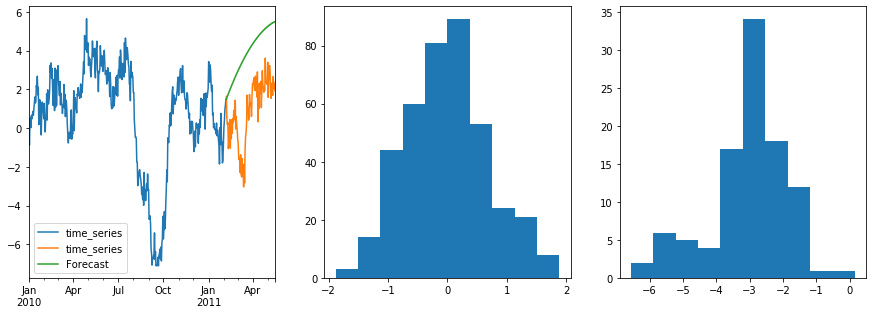

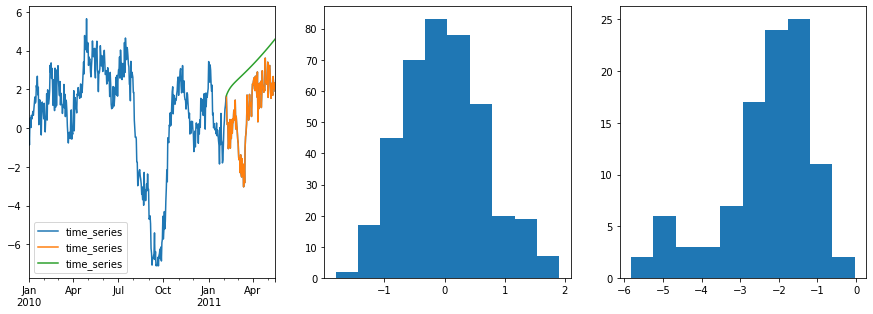

In [17]:
df = df_arima
order = (2, 2, 3)
run_tests(df, order)